In [95]:
#Import you usual Libraries
import numpy as np
import time
import matplotlib.pyplot as plt
from Driven_Gaus_Poly1_TDE import *
from matplotlib.animation import FuncAnimation
import random

# Data Preperation

In [96]:
#Import the Data
SWE_Full = np.load('ForcedSWE_20k_1e-1.npy')
print(SWE_Full.shape)

(3, 10, 10, 20000)


In [97]:
#Here I take cross sections of the 10 by 10 grid into a Reduced SWE data set for testing
SWE_Reduced = np.zeros((75,20000))
xshift = 2
yshift = 2
Dx = 5
Dy = 5
for d in range(3):
    for i in range(Dy):
        for j in range(Dx):
            SWE_Reduced[j+i*Dx+d*Dx*Dy] = SWE_Full[d][i+yshift][j+xshift]

In [98]:
#This is specific to the forcing I used when I generated my data
Nx = 10 #Number of data points along x axis
Ny = 10 #Number of data points along y axis

Lx = Nx*100e3
Ly = Ny*100e3
Force_0 = 1e-5
x = np.linspace(0, Lx, Nx)  # Array with x-points
y = np.linspace(0, Ly, Ny)  # Array with y-points
X, Y = np.meshgrid(x, y)              # Meshgrid
Y = Y[::-1, :]

Forcing = np.zeros((Dx*Dy*3,20000))
Force_0 = 1e-5
for i in range(Dx):
    for j in range(Dy):
        Forcing[j+i*Dx] = -Force_0*np.cos(2*np.pi*Y[i+yshift,j+xshift]/Ly)
Forcing

array([[-1.73648178e-06, -1.73648178e-06, -1.73648178e-06, ...,
        -1.73648178e-06, -1.73648178e-06, -1.73648178e-06],
       [-1.73648178e-06, -1.73648178e-06, -1.73648178e-06, ...,
        -1.73648178e-06, -1.73648178e-06, -1.73648178e-06],
       [-1.73648178e-06, -1.73648178e-06, -1.73648178e-06, ...,
        -1.73648178e-06, -1.73648178e-06, -1.73648178e-06],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [99]:
SWE_Reduced.shape

(75, 20000)

# Training and Forecasting

In [76]:
D = 30               #Dimension of the system
copy = 10            #Number of Time Delay Dimensions
tau = 20             #Time delay between dimensions
length = 10000       #Time to train for
Xdata = SWE_Reduced   #Which Data set to train on
h = 0.1             #Time Scale of the Data
NoCenters = 1000     #Number of Centers

start_time = time.time()
DDF = Gaus_Poly1_TDE()
Center = DDF.KmeanCenter(Xdata,NoCenters,D,length,copy,tau)
print("--- %s seconds ---" % (time.time() - start_time))
np.save('Centers_train10k_1k_D12_C10_tau20.npy',Center)
#Center = np.load('Centers_train10k_1k_D20_tau18.npy')

--- 39.04696607589722 seconds ---


In [77]:
PreLength = 5000    #Forecasting Time
beta,R = 1e-9, 1e-6 #Hyper Parameters Beta and R (Very Important!)
Force = Forcing.T   #Choose the forcing to be used (input it as: Time by Dimension)

X = np.arange(0,PreLength*h,h)
PData = Xdata.T[length-2:]
start_time = time.time()
F = DDF.FuncApproxF(Xdata,length,Center,beta,R,D,copy,tau,Force,h)
print("--- %s seconds ---" % (time.time() - start_time))
Pred = DDF.PredictIntoTheFuture(F,PreLength,PData,Force[length-2:],h)
print("--- %s seconds ---" % (time.time() - start_time))

--- 7.784402847290039 seconds ---
--- 9.627761840820312 seconds ---


<function matplotlib.pyplot.show(close=None, block=None)>

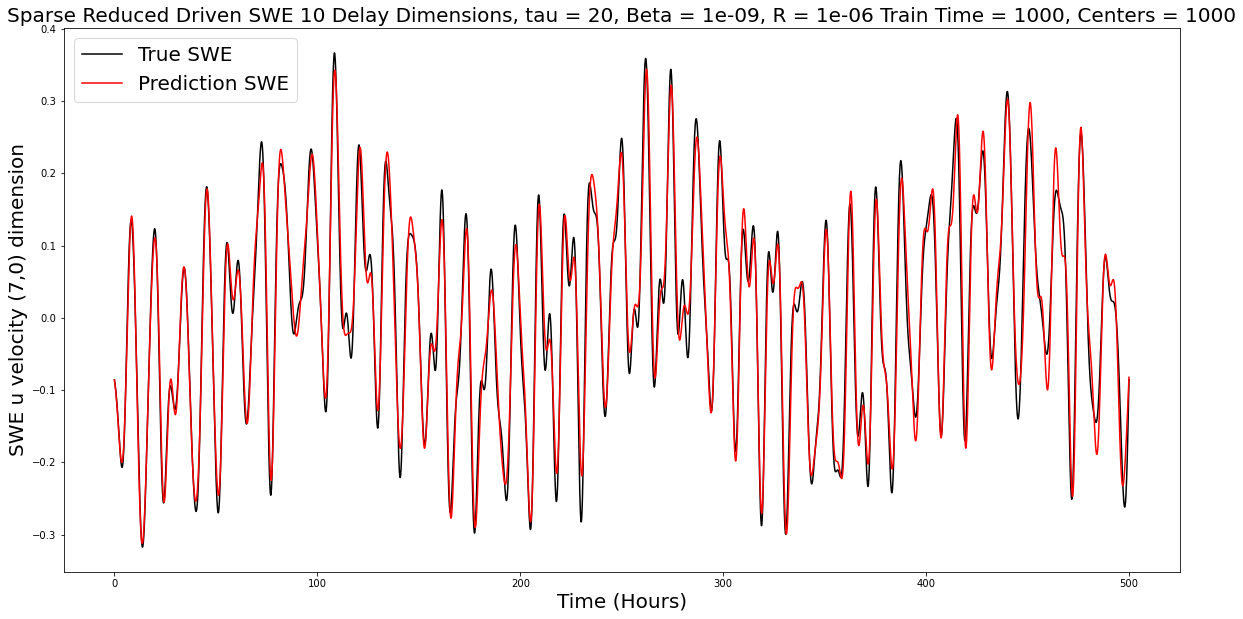

In [80]:
plt.figure(figsize=(20,10))
plt.plot(X,Xdata[0][length+(copy-1)*tau-1:(copy-1)*tau-1+length+PreLength],label = 'True SWE', color = 'black')
plt.plot(X,Pred[0][(copy-1)*tau+1:],label = 'Prediction SWE', color = 'r')
plt.xlabel('Time (Hours)',fontsize=20)
plt.ylabel('SWE u velocity (7,0) dimension',fontsize=20)
plt.legend(fontsize=20)
plt.title('Sparse Reduced Driven SWE 10 Delay Dimensions, tau = 20, Beta = '+str(beta)+', R = '+str(R)+' Train Time = 1000, Centers = 1000',fontsize=20)
plt.savefig('Sparse_from10by10_Forced_Wind_SWE')
plt.show

In [81]:
#Save the Good Data
np.savetxt('TrueSWE_SaprseData.txt',Xdata.T[length+(copy-1)*tau-1:(copy-1)*tau-1+length+PreLength])
np.savetxt('PredictedSWE_SparseData.txt',Pred.T[(copy-1)*tau+1:])

# Grid Sweeping

In [75]:
#Choose your CCC range, this is the number of time Delay Dimensions to Use
#Choose your tau range with Tau
Tau = [16,18,20]
CCC = [20]

In [83]:
#The only thing you'll need to change here is how many i and j loops you want to do and the beta,R line
#If you want to change the sweep through and and beta, you'll change those lines, all is goes unchanged.

for d in CCC:
    for t in Tau:
        D = 30
        copy = d
        tau = t
        length = 10000
        PreLength = 5000
        Xdata = SWE_Sparse
        Force = Forcing.T
        h = 0.1
        NoCenters = 1000

        start_time = time.time()
        DDF = Gaus_Poly1_TDE()
        Center = DDF.KmeanCenter(Xdata,NoCenters,D,length,copy,tau)
        print("--- %s seconds ---" % (time.time() - start_time))
        np.save('Centers_train10k_1k_D'+str(copy)+'_tau'+str(tau)+'.npy',Center)
        
        for i in range(10):
            for j in range(10):
                X = np.arange(0,PreLength*h,h)
                beta,R = 10**(i-12), 10**(j-12)
                PData = Xdata.T[length-2:]

                F = DDF.FuncApproxF(Xdata,length,Center,beta,R,D,copy,tau,Force,h)
                Pred = DDF.PredictIntoTheFuture(F,PreLength,PData,Force[length-2:],h)
                Error = np.sum((Xdata[0][length+(copy-1)*tau+1:(copy-1)*tau+1+length+PreLength]-Pred[0][(copy-1)*tau+1:])**2)
                if True not in np.isnan(Pred):  #This just makes sure there aren't infinities in the prediction because matlab will return an error and stop the looping
                    print('The Error for beta='+str(beta)+'R='+str(R)+'tau='+str(t)+'copy='+str(d)+'is E='+str(Error))
                    plt.figure(figsize=(20,10))
                    plt.plot(Xdata[0][length+(copy-1)*tau+1:(copy-1)*tau+1+length+PreLength],label = 'True SWE', color = 'black')
                    plt.plot(Pred[0][(copy-1)*tau+1:],label = 'Prediction SWE', color = 'r')
                    plt.legend()
                    plt.title('SWE 0.1 time step, Beta = 10^'+str(int(i-12))+', R = 10^'+str(int(j-12))+' Train Time = 1000, Centers = 1000',fontsize=20)
                    plt.savefig('Plot_copy='+str(int(copy))+'tau='+str(int(tau))+'i='+str(int(i))+'j'+str(int(j)))
                    #plt.show

# Make All Animations

In [59]:
DZ = 50 #This is the dimension the water height starts at (0-8 u, 9-17 v, 18-26 z)
Zpred = Pred[DZ:,(copy-1)*tau+1:]
ZTrue = Xdata[DZ:]
space = 5   #Tell Matlab the square grid size (in this case a 3 by 3)
stepsize = 5 #Choose how many time steps to skip before adding a new frame to the video
Frames = 1000 #Number of Frames in the video
minlevel = 485 #Water height level min
maxlevel = 505 #Water height level max


#Make the Prediction Animation
x = np.arange(0,space,1)
y = np.arange(0,space,1)
X,Y = np.meshgrid(x, y)
Z = np.zeros((space,space))
ZP = np.zeros((space,space))
ZT = np.zeros((space,space))

def animateppred(i):
    ax.clear()
    ax.set_title('DDF Surface')
    ax.set_zlim(minlevel,maxlevel)
    for j in range(space):
        for l in range(space):
            ZP[j][l] = Zpred[j*space+l][i*stepsize]
    ax.plot_surface(X, Y, ZP, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

#Make the True Animation
def animatepTrue(i):
    ax.clear()
    ax.set_title('True Surface')
    ax.set_zlim(minlevel,maxlevel)
    for j in range(space):
        for l in range(space):
            ZT[j][l] = ZTrue[j*space+l][length+(copy-1)*tau-1+i*stepsize]
    ax.plot_surface(X, Y, ZT, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    
    
#1 Wire Frame and 1 Surface
X,Y = np.meshgrid(x, y)
Z1 = np.zeros((space,space))
Z2 = np.zeros((space,space))

def animatepBoth(i):
    ax.clear()
    ax.set_title('True Surface')
    ax.set_zlim(minlevel,maxlevel)
    for j in range(space):
        for l in range(space):
            Z1[j][l] = ZTrue[j*space+l][length+(copy-1)*tau-1+i*stepsize]
    for j in range(space):
        for l in range(space):
            Z2[j][l] = Zpred[j*space+l][i*stepsize]
    
    ax.plot_surface(X, Y, Z1, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    #ax.plot_surface(X, Y, Z2, rstride=1, cstride=1,
    #                cmap='binary', edgecolor='none')
    ax.plot_wireframe(X, Y, Z2, color='black')
    ax.set_title('surface');

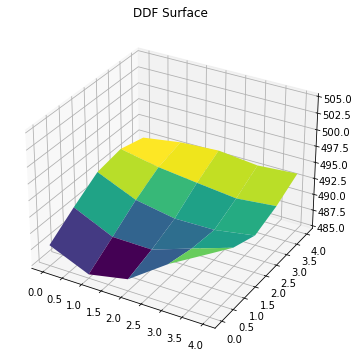

In [60]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection='3d')
ani = FuncAnimation(fig, animateppred, frames=Frames, interval=50, repeat=False)

ani.save('Pred_SWE_Forced.mp4',writer = 'ffmpeg',fps=30)

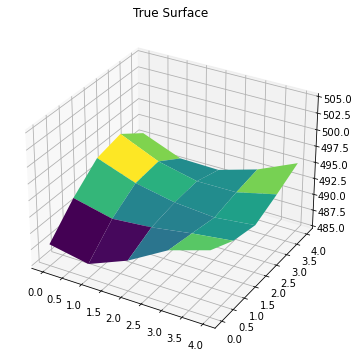

In [61]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection='3d')
ani = FuncAnimation(fig, animatepTrue, frames=Frames, interval=50, repeat=False)

ani.save('True_SWE_Forced.mp4',writer = 'ffmpeg',fps=30)

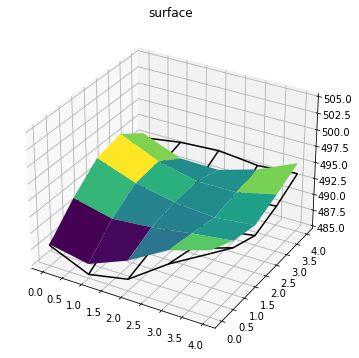

In [62]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection='3d')
ani = FuncAnimation(fig, animatepBoth, frames=Frames, interval=50, repeat=False)

ani.save('Both_SWE_Forced.mp4',writer = 'ffmpeg',fps=30)

# Prediction 3D Picture

In [79]:
Zpred = SWE_Reduced[50:]

In [80]:
Zpred.shape

(25, 20000)

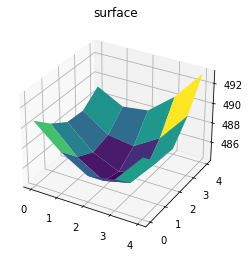

In [81]:
i = 3120
space = 5
x = np.arange(0,space,1)
y = np.arange(0,space,1)
X,Y = np.meshgrid(x, y)
Z = np.zeros((space,space))
for j in range(space):
    for l in range(space):
        Z[j][l] = Zpred[j*space+l][i]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');